In [1]:
import sklearn as skl
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import pandas as pd
from skimage import filters
import sys
sys.path.append('/Users/kategroschner/Documents/pyNanoFind/utilities/')
import realDataProcess as rdp
from skimage import exposure
from skimage import morphology as morph
from skimage.util import invert
from skimage import feature
import ipywidgets as widgets
from ipywidgets import interact, interactive
from numpy import random
import freqCutting as fcut
from scipy import fftpack
from skimage.filters import gaussian

In [2]:
data = h5py.File('/Users/kategroschner/Downloads/Chiral_D_2018_10_31_FilteredStack.emd','r')
subdata = data['data']
subdata = subdata['Masked Particles']
subdata = subdata['data'][:,:,:]

In [3]:
labels = np.loadtxt('/Users/kategroschner/Downloads/Chiral_D_ManualValues_2018_10_31.csv',delimiter=',')

In [4]:
count_l = 0
count_r = 0
for l in labels:
    if l == 4:
        count_l += 1
    elif l == 6:
        count_r += 1
print('left: ', count_l, 'right: ', count_r)

count_g = 0
count_idk = 0
for l in labels:
    if l == 0:
        count_g += 1
    elif l == 5:
        count_idk += 1
print('garbage: ', count_g, 'idk: ', count_idk)

left:  90 right:  97
garbage:  767 idk:  46


In [5]:
def balance(images, labels, min_num_labels):
    final_image = []
    final_labels = []
    count_left = 0
    count_right = 0
    count_garbage = 0
    count_idk = 0
    for idx, l in enumerate(labels):
        if l == 4:
            if count_left < min_num_labels:
                final_image.append(images[idx])
                final_labels.append(l)
                count_left+=1
        if l == 5:
            if count_idk < min_num_labels:
                final_image.append(images[idx])
                final_labels.append(l)
                count_idk += 1
        if l == 6:
            if count_right < min_num_labels:
                final_image.append(images[idx])
                final_labels.append(l)
                count_right += 1
        if l == 0:
            if count_garbage < min_num_labels:
                final_image.append(images[idx])
                final_labels.append(l)
                count_garbage += 1
    return np.array(final_image),np.array(final_labels)

In [6]:
final_images, final_labels = balance(subdata,labels,46)

In [7]:
np.save('particles.npy',final_images)

In [8]:
np.save('labels.npy',final_labels)

In [183]:
sort_img, sort_labels = shuffle(final_images,final_labels)

In [184]:
np.save('sorted_particles.npy',sort_img)
np.save('sorted_labels.npy',sort_labels)

In [4]:
sort_img = np.load('sorted_particles.npy')
sort_labels = np.load('sorted_labels.npy')

In [5]:
# DOING MACHINE LEARNING


def train_random_forest(X_train, Y_train, nestimators = 50,crit='gini',max_feat='auto'):
    """function that takes in the training feature set and training labels and trains a radnom forest with 
    n estimators given by nestimators"""
    classifier = RandomForestClassifier(n_estimators= nestimators,criterion= crit,max_features=max_feat)
    classifier.fit(X_train, Y_train)
    return classifier

def cross_val_stratified(X,Y,model,nsplit):
    """runs stratified k-fold cross validation where nsplit specifies the number of splits
    and returns the mean and standard deviation of the cross validation score. Based on the code shown in 
    class."""
    cv = StratifiedKFold(n_splits=nsplit)
    scores = cross_val_score(model, X, Y, cv=cv, n_jobs=-1)
    print("mean: {:3f}, stdev: {:3f}".format(
        np.mean(scores), np.std(scores)))

def plot_confusion_matrix(Y, Y_pred, labels):
    """Creates a confusion matrix for the different classes given a set of features, true labels, the dataset
    and the desired trained classfier"""
    cfm = metrics.confusion_matrix(Y, Y_pred, labels=labels)
    df_cfm = pd.DataFrame(data = cfm, columns=labels, index=labels)
    plt.subplots(figsize=(5,5))
    ax = sns.heatmap(df_cfm, annot=True, fmt="d",cmap='rainbow')



In [6]:
sort_img.shape

(184, 200, 200)

In [9]:
test = fftpack.fft2(sort_img[0])

In [61]:
aperture = np.zeros((200,200))
for x in np.arange(-100,100):
    for y in np.arange(-100,100):
        r = np.sqrt(x**2+y**2)
        if r > 100:
            aperture[x,y] = 1
aperture = fftpack.fftshift(aperture)

In [62]:
aperture = gaussian(aperture,1)

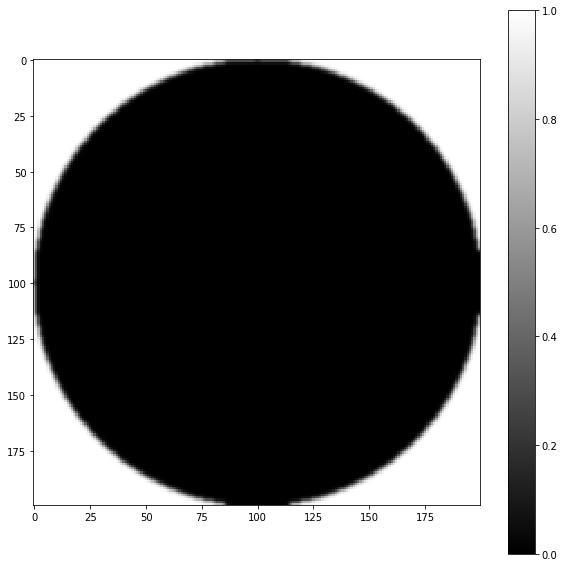

In [63]:
rdp.imm(aperture,(200,200))

In [72]:
test = fftpack.fft2(sort_img[100].copy())*aperture
test = abs(fftpack.ifft2(test))

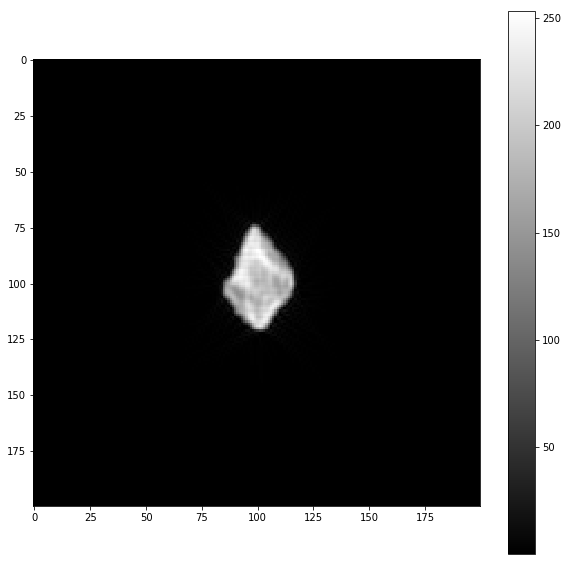

In [73]:
rdp.imm(test,(200,200))

In [74]:
s = filters.sobel(test)

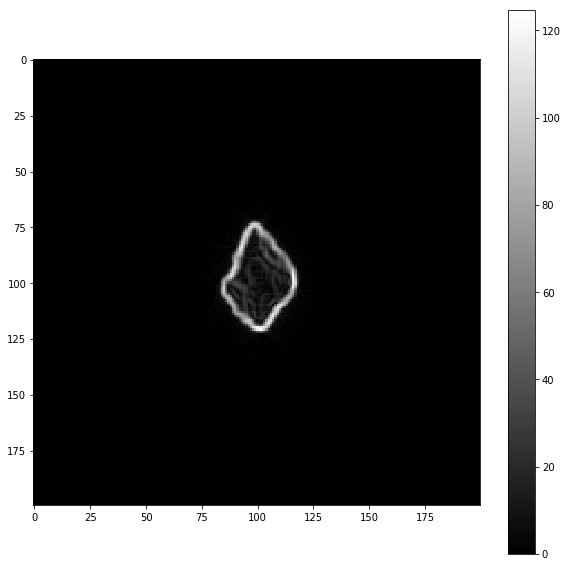

In [75]:
rdp.imm(s,(200,200))

In [76]:
s = filters.sobel(sort_img[4].copy())

In [83]:
s[s>100] = 0

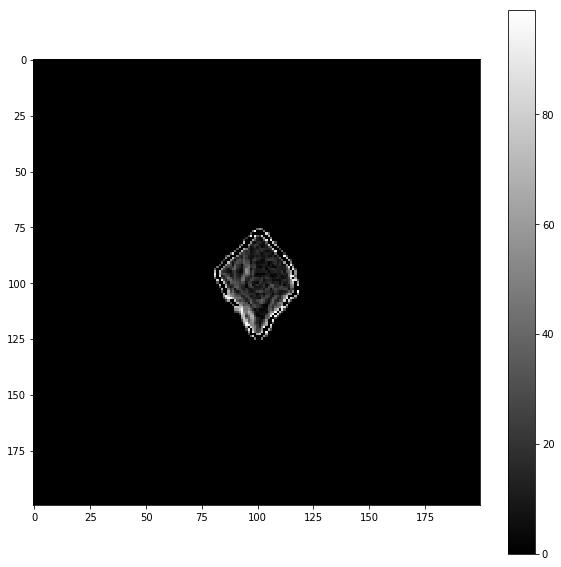

In [84]:
rdp.imm(s,(200,200))

In [90]:
c = feature.corner_peaks(feature.corner_harris(sort_img[4]))

In [86]:
c.shape

(6, 2)

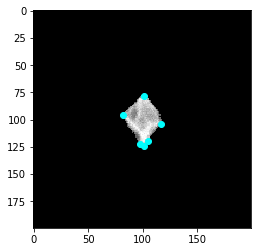

In [91]:
fig, ax = plt.subplots()
ax.imshow(sort_img[4], cmap=plt.cm.gray)
ax.plot(c[:, 1], c[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)

In [102]:
vals = [sort_img[4][i[0],i[1]] for i in c]

In [100]:
c[0]

array([ 78, 101])

In [98]:
sort_img[4].shape

(200, 200)

In [101]:
sort_img[4][78,101]

220.0

In [95]:
c

array([[ 78, 101],
       [ 96,  82],
       [104, 117],
       [120, 105],
       [122,  98],
       [124, 101]])

In [105]:
vals = np.array(vals)

In [106]:
v = vals.mean()

In [107]:
v

167.16666666666666

In [108]:
test = sort_img[4].copy()

In [113]:
test[test<120] = v

In [114]:
test = gaussian(test,1)

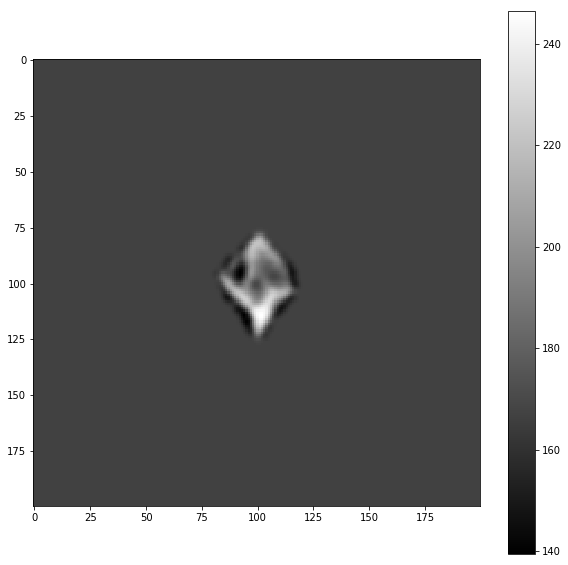

In [115]:
rdp.imm(test,(200,200))

In [20]:
sobel_feat = np.zeros(final_images.shape)
for idx,img in enumerate(final_images):
    s = filters.sobel(img)
    sobel_feat[idx] = s

In [54]:
scharr_feat = np.zeros(final_images.shape)
for idx,img in enumerate(final_images):
    s = filters.scharr(img)
    scharr_feat[idx] = s

In [44]:
test_feat = np.zeros(final_images.shape)
for idx,img in enumerate(final_images):
    s = morph.skeletonize(img)
    test_feat[idx] = s

ValueError: Image contains values other than 0 and 1

In [21]:
sobel_feat.shape

(184, 200, 200)

In [79]:
t = scharr_feat[0].copy()
t[t>0.1] = 1

In [80]:
w = t.copy()
w[w<1] = 0

In [81]:
q = morph.skeletonize(w)

In [82]:
z = morph.binary_closing(q,morph.disk(2))

In [95]:
skel_feat = np.zeros(final_images.shape)
for idx,img in enumerate(scharr_feat):
    s = img.copy()
    s[s>0.1] = 1
    s[s<1] = 0
    s = morph.skeletonize(s)
    skel_feat[idx] = s

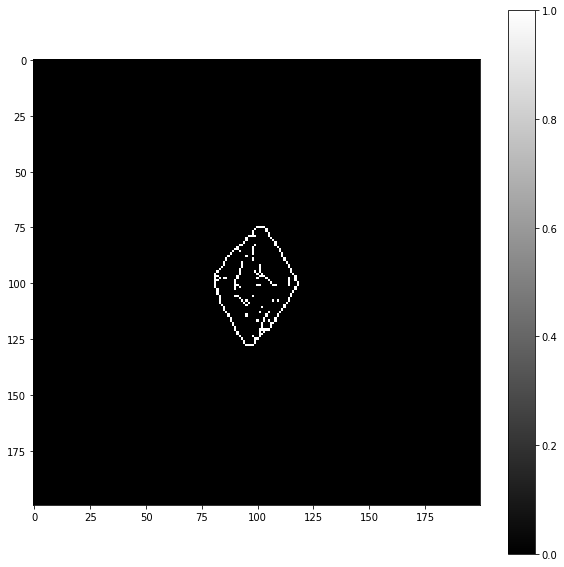

In [96]:
rdp.imm(skel_feat[4],size=(200,200))

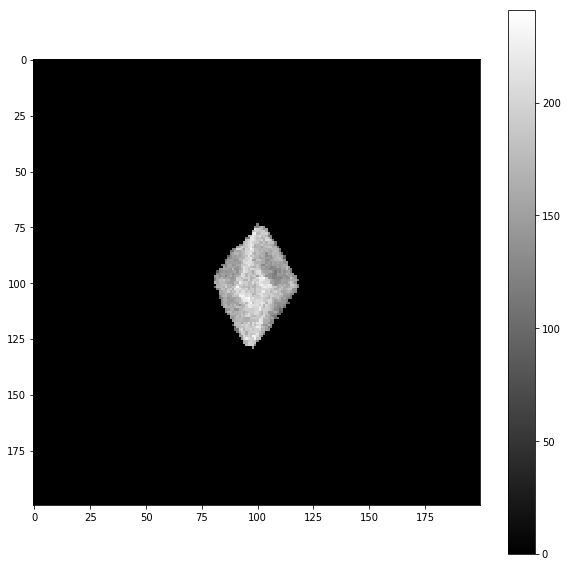

In [94]:
rdp.imm(final_images[4],(200,200))

In [47]:
final_labels

array([ 6.,  0.,  5.,  6.,  4.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,  6.,
        0.,  6.,  0.,  0.,  5.,  4.,  0.,  0.,  0.,  0.,  6.,  0.,  4.,
        6.,  0.,  4.,  0.,  0.,  0.,  0.,  6.,  0.,  0.,  4.,  5.,  4.,
        0.,  0.,  0.,  4.,  6.,  5.,  0.,  5.,  4.,  0.,  0.,  6.,  5.,
        0.,  6.,  4.,  4.,  0.,  0.,  0.,  5.,  5.,  0.,  0.,  5.,  0.,
        0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,  0.,
        4.,  6.,  4.,  5.,  6.,  5.,  6.,  6.,  4.,  5.,  5.,  4.,  4.,
        5.,  4.,  5.,  6.,  5.,  6.,  6.,  6.,  6.,  4.,  5.,  4.,  4.,
        6.,  4.,  4.,  4.,  4.,  5.,  6.,  6.,  6.,  4.,  5.,  6.,  6.,
        4.,  6.,  6.,  4.,  5.,  5.,  4.,  5.,  4.,  6.,  4.,  4.,  4.,
        6.,  4.,  4.,  6.,  4.,  6.,  6.,  5.,  6.,  5.,  5.,  4.,  5.,
        5.,  5.,  4.,  5.,  6.,  6.,  4.,  4.,  4.,  5.,  5.,  6.,  4.,
        4.,  6.,  4.,  4.,  6.,  6.,  6.,  4.,  6.,  4.,  4.,  6.,  6.,
        5.,  6.,  5.,  6.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5

In [97]:
% matplotlib notebook

<IPython.core.display.Javascript object>


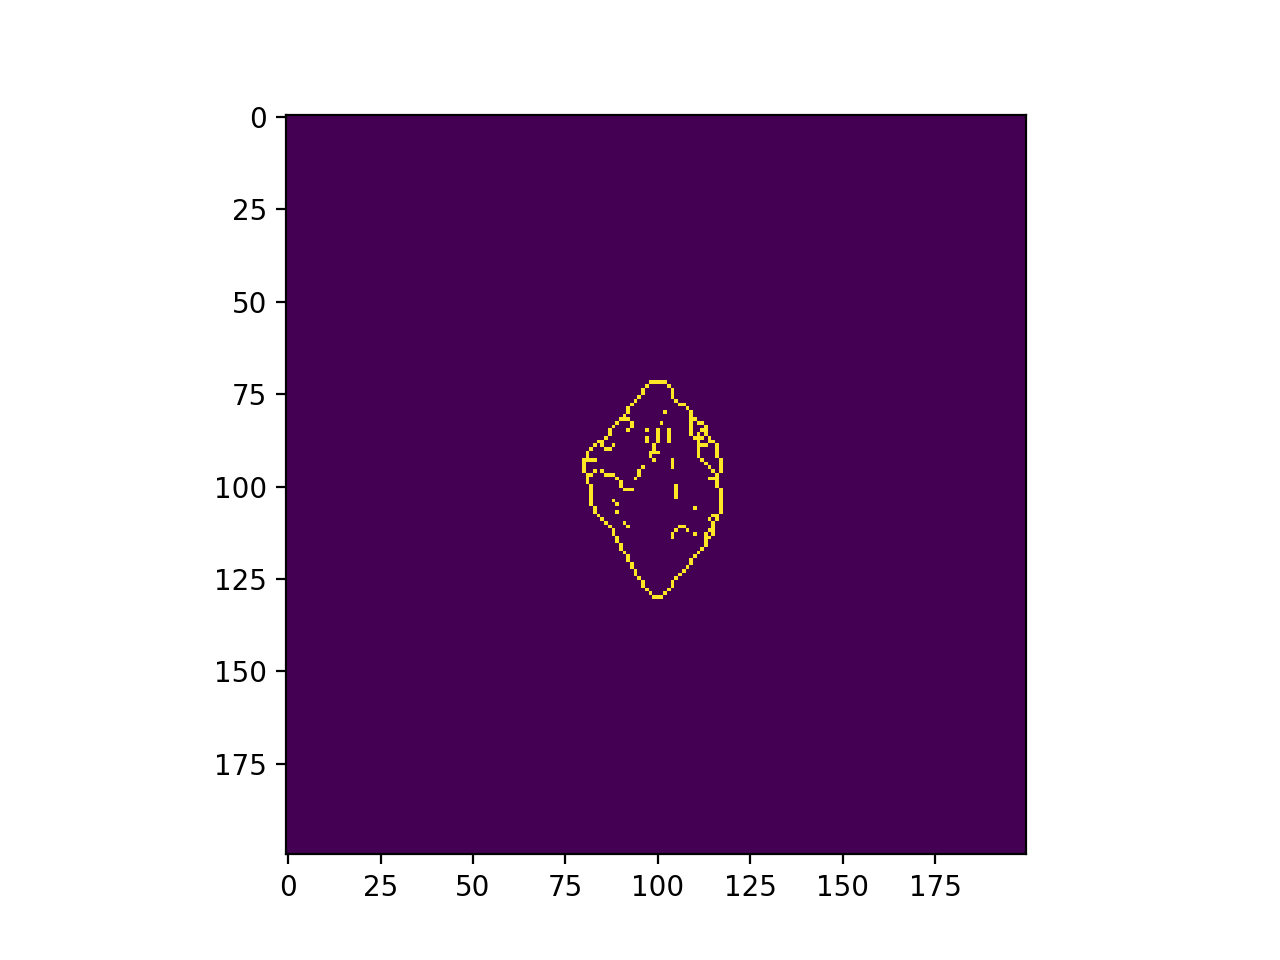

interactive(children=(IntSlider(value=91, description='i', max=183), Output()), _dom_classes=('widget-interact…

In [100]:
fg1, ax1 = plt.subplots(1,1)
imax1 = ax1.imshow(skel_feat[0,:,:],
                   vmin=0,vmax = 1) # Set the initial image and intenstiy scaling 

# Updates the plot
def axUpdate(i):
    imax1.set_data(skel_feat[i,:,:])

# Create the slider to update the plot
w = interactive(axUpdate, i=(0,skel_feat.shape[0]-1))
display(w)

In [104]:
len(labels)

1000

In [142]:
skel_feat.shape

(184, 200, 200)

In [121]:
def shuffle(img_stack,labels):
    vals = np.arange(0,len(labels))
    random.shuffle(vals)
    new_stack = np.zeros(img_stack.shape)
    new_labels = np.ones(labels.shape)
    for old_idx,new_idx in enumerate(vals):
        new_stack[old_idx] = img_stack[new_idx]
        new_labels[old_idx] = labels[new_idx]
    return new_stack,new_labels

In [122]:
feat, chirality = shuffle(skel_feat,final_labels)

In [124]:
chirality

array([ 0.,  4.,  0.,  4.,  6.,  4.,  6.,  4.,  6.,  5.,  6.,  0.,  5.,
        5.,  5.,  6.,  5.,  4.,  0.,  0.,  0.,  5.,  4.,  5.,  4.,  6.,
        0.,  0.,  6.,  6.,  4.,  5.,  4.,  6.,  6.,  4.,  4.,  0.,  4.,
        4.,  0.,  5.,  4.,  6.,  6.,  6.,  6.,  6.,  0.,  6.,  0.,  6.,
        4.,  5.,  5.,  6.,  5.,  5.,  5.,  4.,  0.,  5.,  5.,  0.,  6.,
        4.,  4.,  0.,  4.,  5.,  4.,  6.,  5.,  6.,  5.,  4.,  5.,  6.,
        4.,  0.,  6.,  6.,  4.,  4.,  0.,  0.,  0.,  6.,  6.,  0.,  5.,
        0.,  4.,  5.,  0.,  0.,  0.,  5.,  6.,  5.,  6.,  6.,  0.,  4.,
        6.,  4.,  0.,  5.,  5.,  4.,  5.,  0.,  0.,  4.,  4.,  4.,  5.,
        6.,  5.,  5.,  0.,  5.,  5.,  0.,  0.,  0.,  4.,  4.,  5.,  5.,
        4.,  6.,  6.,  0.,  4.,  5.,  4.,  0.,  4.,  0.,  5.,  4.,  4.,
        0.,  6.,  4.,  0.,  0.,  6.,  6.,  6.,  4.,  0.,  0.,  0.,  6.,
        6.,  0.,  4.,  4.,  0.,  5.,  0.,  5.,  5.,  4.,  6.,  5.,  5.,
        5.,  6.,  5.,  0.,  5.,  0.,  5.,  4.,  6.,  6.,  6.,  6

In [119]:
vals = np.arange(0,len(final_labels))
random.shuffle(vals)

In [125]:
feat.shape

(184, 200, 200)

In [120]:
vals

array([161,  76,  37, 176, 119,  63,  61, 143,   3,   4,  52, 141, 117,
        82, 100, 169, 156, 151,  47,   6,  51,  58, 129,  29,  18,  69,
        77,  90,  87, 139, 138, 163,  59,  23,  67,  46,  88,  92,  75,
        57,  65, 134,  10,  84, 104,  31,  78,  11,  60,  28,  85, 146,
        24, 172, 159,  43, 170, 102,   0, 135,  94, 149, 103,  86,  42,
        27,  98, 147,  93,  64,  20, 111,  97, 130, 132, 158,  16, 166,
        50,  40,  71,  32,  91, 167, 109, 154,  22,   2, 137,  48,  55,
        36, 140, 174, 175, 108, 182,  19,  21, 179, 113,  53,  41, 177,
       152,  45, 165, 148,  72, 157,  95, 142,  17,  89,  12, 106,  25,
       121,  15,   1, 150,   9,  33, 107,  49, 115,  74,  13, 164,   8,
       124, 168,  70, 126,  80, 180, 125, 162,  68,  39,  96,   5,  81,
       145,  99, 116, 101,  14, 110,  44, 178,  54,  83,  38,  62,  30,
       144, 118, 122, 183, 112,  34, 128, 160,  79, 120, 105, 114, 173,
        26,  66, 127, 153, 181, 155, 123,  73,  35, 136, 133, 13

In [128]:
feat_1d = []
for idx, f in enumerate(feat):
    t = f[50:150,50:150]
    t = t.flatten()
    feat_1d.append(t)
feat_1d = np.array(feat_1d)

In [129]:
train_X = feat_1d[:184-92]
train_Y = chirality[:184-92]
test_X = feat_1d[184-92:184-46]
test_Y = chirality[184-92:184-46]

In [136]:
model = train_random_forest(train_X,train_Y)

In [133]:
from sklearn.ensemble import RandomForestClassifier

In [137]:
predicted = model.predict(test_X)
#getting the percent accurate
metrics.accuracy_score(test_Y,predicted)*100

56.521739130434781

<IPython.core.display.Javascript object>


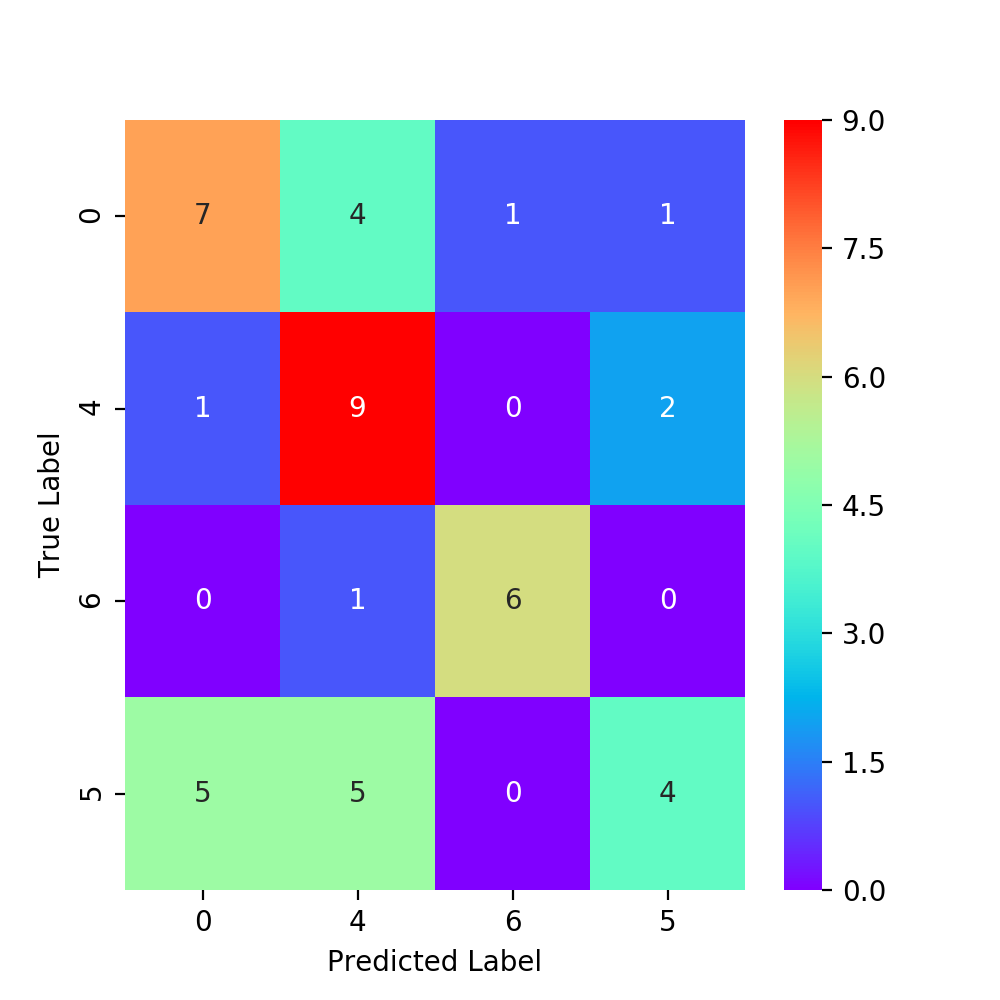

Text(0.5,25.7222,'Predicted Label')

In [141]:
plot_confusion_matrix(test_Y,predicted,[0, 4, 6,5])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

## Try whole image

In [173]:
img_1d = []
for idx, f in enumerate(final_images):
    t = f[50:150,50:150]
    t = t.flatten()
    img_1d.append(t)
img_1d = np.array(img_1d)

In [174]:
shuf_img1d, shuf_labels = shuffle(img_1d,final_labels)

In [176]:
for idx,i in enumerate(shuf_labels):
    if i == 5:
        shuf_labels[idx] = 0

In [177]:
train_X = shuf_img1d[:184-92]
train_Y = shuf_labels[:184-92]
test_X = shuf_img1d[184-92:184-46]
test_Y = shuf_labels[184-92:184-46]

In [178]:
model = train_random_forest(train_X,train_Y)

In [179]:
predicted = model.predict(test_X)
#getting the percent accurate
metrics.accuracy_score(test_Y,predicted)*100

73.91304347826086

<IPython.core.display.Javascript object>


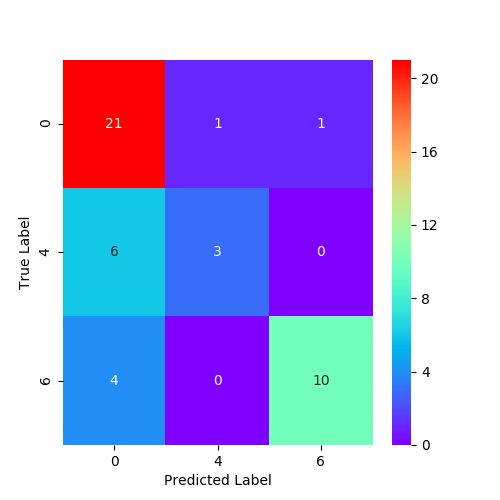

Text(0.5,25.7222,'Predicted Label')

In [181]:
plot_confusion_matrix(test_Y,predicted,[0, 4, 6])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

In [157]:
comb_feat = []
for idx, f in enumerate(final_images):
    edge = skel_feat[idx].flatten()
    combined = np.concatenate((f.flatten(),edge))
    comb_feat.append(combined)
comb_feat = np.array(comb_feat)

In [158]:
comb_feat.shape

(184, 80000)

In [165]:
comb_feat, shuf_labels = shuffle(comb_feat,final_labels)

In [169]:
train_X = comb_feat[:184-92]
train_Y = shuf_labels[:184-92]
test_X = comb_feat[184-92:184-46]
test_Y = shuf_labels[184-92:184-46]

In [170]:
model = train_random_forest(train_X,train_Y)

In [171]:
predicted = model.predict(test_X)
#getting the percent accurate
metrics.accuracy_score(test_Y,predicted)*100

56.521739130434781

<IPython.core.display.Javascript object>


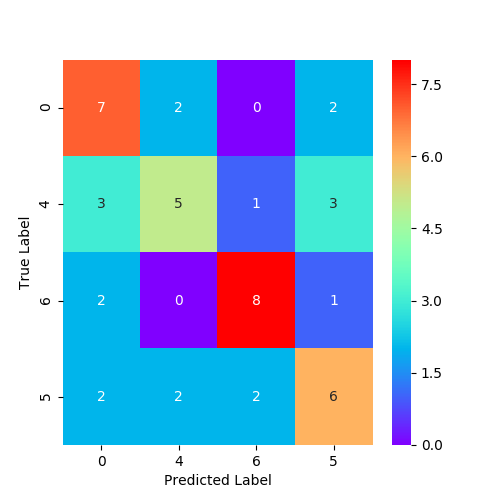

Text(0.5,25.7222,'Predicted Label')

In [172]:
plot_confusion_matrix(test_Y,predicted,[0, 4, 6,5])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')